## Preparing the dataset

In [79]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
              "and extraction."
        )
        return

    #1 Downloads the file
    with urllib.request.urlopen(url) as response:    
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    #2 Unzips the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:    
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"

    #3 Adds a .tsv file extension
    os.rename(original_file_path, data_file_path)               
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [80]:
import pandas as pd
df = pd.read_csv(
    data_file_path, sep = "\t", 
    header = None, names = ["Label", "Text"] 
)

#1 Renders the data frame in a Jupyter notebook. Alternatively, use print(df).
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [81]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [82]:
# creating a balanced dataset

def create_balanced_dataset(df):
    # 1 Counts the instances of “spam”
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # 2 Randomly samples "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state = 123
    )

    # 3 Combine ham subset with "spam"
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


In [83]:
balanced_df["Label"] = balanced_df["Label"].map({
    "ham": 0,
    "spam": 1
})

## Spliting the dataset

In [84]:
def random_split(df, train_frac, validation_frac):
    #1 Shuffles the entire DataFrame
    df = df.sample(
        frac = 1, random_state = 123
    ).reset_index(drop=True)

    #2 Calculates split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    #3 Splits the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

#4 Test size is implied to be 0.2 as the remainder.
train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1
)


In [85]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Creating data loaders

In [86]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special = {"<|endoftext|>"}))

[50256]


In [87]:
# Setting up a Python Datatset class

import torch
import torch.nn as nn
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length = None,
                 pad_token_id = 50256):        
        self.data = pd.read_csv(csv_file)

        #1 Pretokenizes texts
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        #2 Truncates sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

        #3 Pads sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype = torch.long),
            torch.tensor(label, dtype = torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        
        return max_length


In [88]:
train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)

In [89]:
print(train_dataset.max_length)

120


In [90]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [91]:
# creating PyTorch data loaders
from torch.utils.data import DataLoader

# 1 This setting ensures compatibility with most computers.
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [92]:
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [93]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Initializing a model with pretrained weights

In [94]:
# Configuration

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"


#1 Vocabulary size
#2 Context length
#3 Dropout rate
#4 Query-key-value bias

BASE_CONFIG = {
    "vocab_size": 50257,          #1
    "context_length": 1024,       #2
    "drop_rate": 0.0,             #3
    "qkv_bias": True              #4
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

## Modules

In [95]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout,
                 num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # 1

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # 2

        self.dropout = nn.Dropout(dropout) 
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1),
        ) 

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # 3
        queries = self.W_query(x) # 3
        values = self.W_value(x) # 3

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # 4
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2) # 5
        queries = queries.transpose(1, 2) # 5
        values = values.transpose(1, 2) # 5

        attn_scores = queries @ keys.transpose(2, 3) # omega # 6
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # 7

        attn_scores.masked_fill_(mask_bool, -torch.inf) # 8

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) # 9
        context_vec = context_vec.contiguous().view( # 10
            b, num_tokens, self.d_out
        )

        context_vec = self.out_proj(context_vec) # 11
        return context_vec

In [96]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # layers to train the model
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                (x + 0.044715 * torch.pow(x, 3))
            )
        )

In [97]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # multi-head attention
        self.att = MultiHeadAttention(
            # input dim
            d_in = cfg["emb_dim"],
            # output dim
            d_out = cfg["emb_dim"],
            # actual input length
            context_length = cfg["context_length"],
            # number of causal attention 
            num_heads = cfg["n_heads"],
            # masking rate
            dropout = cfg["drop_rate"],
            # if adding query, key, and value bias
            qkv_bias = cfg["qkv_bias"]
        )

        # Apply layers and activation function to train the model
        self.ff = FeedForward(cfg)

        # normalization
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        
        # masking
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # 1

        # assgin input as shortcut
        shortcut = x

        # normalize input
        x = self.norm1(x)

        # get context vector
        x = self.att(x)

        # dropout
        x = self.drop_shortcut(x)

        # shortcut: add input to output 
        x = x + shortcut # 2

        # assgin transformed input to shortcut 
        shortcut = x # 3

        # normalizing
        x = self.norm2(x)

        # apply linear layers and activation functions to input
        x = self.ff(x)

        # drop
        x = self.drop_shortcut(x)

        # shortcut: add input to output 
        x = x + shortcut # 4

        return x

In [98]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # create token embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], cfg["emb_dim"])

        # create positional embeddings
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # set drop out rate
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Apply transfomer block with n_layers
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Apply layer normalization to embedding layers
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # create output layers
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # create token embeddings
        tok_embeds = self.tok_emb(in_idx)

        # create positional embeddings
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device) # 1
        )
        
        # combine token and positional embeddings
        x = tok_embeds + pos_embeds

        # drop some layers
        x = self.drop_emb(x)

        # apply transformer blocksbb
        x = self.trf_blocks(x)

        # normalizing
        x = self.final_norm(x)

        # apply linear function to x and return probbaility of each token and text
        logits = self.out_head(x)
        
        return logits

In [99]:
def generate_text_simple(model, idx,  # 1
                         max_new_tokens, context_size):
    
    # iterate number of max new tokens provided
    for _ in range(max_new_tokens):

        # extract last number of context size
        idx_cond = idx[:, -context_size:] # 2

        # Disables gradient tracking since we are not training yet
        with torch.no_grad():
            # Obtain logits
            logits = model(idx_cond)

        # only extract the last row from a tensor
        logits = logits[:, -1, :] # 3

        # Obtain probability through softmax
        # Probability of each token in vocabulary
        probas = torch.softmax(logits, dim = -1) # 4
        
        # find the max probability
        idx_next = torch.argmax(probas, dim = -1, keepdim = True) # 5
        
        # find the index corresponding to the max proba
        idx = torch.cat((idx, idx_next), dim = 1) # 6

    return idx

In [100]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    # 1
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    # 2
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [101]:
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):           
    #1 Sets the model’s positional and token embedding weights to those specified in params.
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    #2 Iterates over each transformer block in the model
    for b in range(len(params["blocks"])):

        #3 The np.split function is used to divide the attention and bias weights into 
        # three equal parts for the query, key, and value components.

        # attention weights
        q_w, k_w, v_w = np.split(                            
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # bias weights
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        # weight tensor for the output projection layer
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # weight and bias from layers
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # normalizing 
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    #4 he original GPT-2 model by OpenAI reused the token embedding weights in the output layer to 
    # reduce the total number of parameters, which is a concept known as weight tying.
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [102]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    # 1 Logits of last output token
    logits = model(input_batch)[:, -1, :]
    # calculate the cross entropy
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

#1 Iteratives over all batches if no fixed num_batches is specified
#2 Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader
#3 Sums loss for each batch
#4 Averages the loss over all batches

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)     #1
    else:
        num_batches = min(num_batches, len(data_loader))   #2
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()    #3
        else:
            break
    return total_loss / num_batches    #4


def evaluate_model(model, train_loader, val_loader, 
                   device, eval_iter):
    # 1 Dropout is disabled during evaluation for stable, reproducible results.
    model.eval()
    with torch.no_grad():
        # 2 Disables gradient tracking, which is not required during evaluation, 
        #   to reduce the computational overhead
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches = eval_iter
        )
        
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches = eval_iter
        )
    
    model.train()
    return train_loss, val_loss

In [103]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
setting, params = download_and_load_gpt2(
    model_size = model_size,
    models_dir = "gpt2"
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [104]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [105]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [106]:
# Before fine-tuning the model as a spam classifier
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " seleceted to recevice $1000 cash or $2000 award.'"
)

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_2, tokenizer),
    max_new_tokens = 23,
    context_size = BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially seleceted to recevice $1000 cash or $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Adding a classification head

In [107]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [108]:
# Freeze the model meaning that we make all layers nontrainable
for param in model.parameters():
    param.requires_grad = False

In [109]:
# Adding a classification layer

torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features = BASE_CONFIG["emb_dim"],
    out_features = num_classes
)

In [110]:
# make the final LayerNORM AND last transformer block trainable, we set their respective requires_grad to True
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [111]:
# Fine-tuning the whole model

inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs: ", inputs)

# 1 shape: (batch_size, num_tokens)
print("Inputs dimensions: ", inputs.shape)

Inputs:  tensor([[5211,  345,  423,  640]])
Inputs dimensions:  torch.Size([1, 4])


In [112]:
with torch.no_grad():
    outputs = model(inputs)
    
print("Outputs: \n", outputs)
print("Outputs dimensions: ", outputs.shape)

Outputs: 
 tensor([[[-1.5883,  0.9920],
         [-3.7208,  7.4510],
         [-2.2642,  6.6005],
         [-3.5965,  3.9889]]])
Outputs dimensions:  torch.Size([1, 4, 2])


In [113]:
print("Last output token: ", outputs[:, -1, :])

Last output token:  tensor([[-3.5965,  3.9889]])


## Calculating the classification loss and accuracy

In [114]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5965,  3.9889]])


In [115]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [116]:
def calc_accuracy_loader(data_loader, model, device, num_batches = None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        # Ensures number of batches doesn’t exceed batches in data loader
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # .to(device): use GPU or CPU
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                # Logits of last output token
                logits = model(input_batch)[:, -1, :]

                # find the predicted labels with max softmax probabilities 
                #   that only has two values in a vector
                predicted_labels = torch.argmax(logits, dim = -1)
            
            # find the number of labels
            num_examples += predicted_labels.shape[0]

            # find the correct prediction
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    
    # return average accuracy
    return correct_predictions / num_examples

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches = 10
)

val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches = 10
)

test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches = 10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [119]:
def calc_loss_loder(data_loader, model, device, num_batches = None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 1 Ensures number of batches doesn’t exceed batches in data loader
        num_batches = min(num_batches, len(data_loader))
    
    # iterate every single batch to calculate the loss values
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # add all loss values
            total_loss += loss.item()
        else:
            break
        
    # return the average loss value
    return total_loss / num_batches


In [120]:
with torch.no_grad():
    train_loss = calc_loss_loder(
        train_loader, model, device, num_batches = 5
    )

    val_loss = calc_loss_loder(val_loader, model, device, num_batches = 5)
    test_loss = calc_loss_loder(test_loader, model, device, num_batches = 5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.445
Validation loss: 2.575
Test loss: 2.314


## Fine-tuning the model on supervised data

In [121]:
def train_classifier_simple(
        model, train_loader, val_loader, 
        optimizer, device, num_epochs, eval_freq, eval_iter):
    
    # 1 Initialize lists to track losses and examples seen

    # training and validation loss
    # training exmaples seen, validation examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    # 2 Main training loop
    for epoch in range(num_epochs):
        # 3 Sets model to training mode
        model.train()

        for input_batch, target_batch in train_loader:
            # 4 Resets loss gradients from the previous batch iteration
            optimizer.zero_grad()

            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # 5 Calculates loss gradients
            loss.backward()

            # 6 Updates model weights using loss gradients
            optimizer.step()

            # 7 New: tracks examples instead of tokens
            examples_seen += input_batch.shape[0]

            global_step += 1

            # 8 Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        
        # 9 Calculates accuracy after each epoch
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [122]:
import time 

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, exmaples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, 
    device, num_epochs = num_epochs, eval_freq = 50,
    eval_iter = 5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.146, Val loss 2.383
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.524, Val loss 0.558
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.354
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.334, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.341, Val loss 0.308
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.144, Val loss 0.210
Ep 4 (Step 000450): Train loss 0.157, Val loss 0.136
Ep 4 (Step 000500): Train loss 0.224, Val loss 0.139
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.145
Ep 5 (Step 000600): Train loss 0.085, Val loss 0.075
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 10.12 m

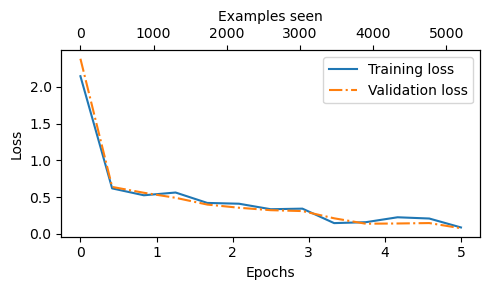

In [128]:
import matplotlib.pyplot as plt

#1 Plots training and validation loss against epochs
#2 Creates a second x-axis for examples seen
#3 Invisible plot for aligning ticks
#4 Adjusts layout to make room

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

 #1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

 #2
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)    #3
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()             #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, exmaples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

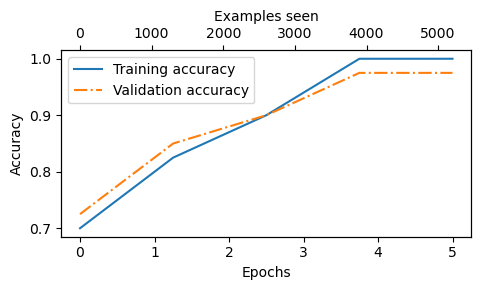

In [129]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, exmaples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [126]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.12%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## Using the LLM as a spam classifier

In [130]:
def classify_review(
        text, model, tokenizer, device, max_length = None,
        pad_token_id = 50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    # 1 Prepares inputs to the model
    supported_context_length = model.pos_emb.weight.shape[1]

    # 2 Truncates sequences if they are too long
    inputs_ids = input_ids[:min(max_length, supported_context_length)]

    # 3 Pads sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    # 4 Adds batch dimension
    input_tensor = torch.tensor(
        input_ids, device = device
    ).unsqueeze(0)

    #5 Models inference without gradient tracking
    with torch.no_grad():
        #6 Logits of the last output toke                               
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    #7 Returns the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [131]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [132]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [133]:
torch.save(model.state_dict(), "review_classifier.pth")

In [135]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

C:\Users\42128\AppData\Local\Temp\ipykernel_41708\379311099.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth")


<All keys matched successfully>